![UPC Logo](https://i.imgur.com/xfLgy6a.png)

# **Data Mining - Trabajo Parcial 2021-1**

### Classroom: CC81
### Professor: Luis Martín Canaval

Statement: For this project we've been asked to choose a dataset from Kaggle and design a neural network utilizing deep learning techniques like convolutional ANN.

### Members:
- Renzo Damian
- Renzo Mondragón




In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## 1. The Dataset

The chosen dataset is the Stanford Dogs dataset that contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.


[From Kaggle Stanford Dogs](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset)

In [ ]:
!unzip archive.zip

## 2. Preprocessing

We got a folder that has the images of the 120 breeds of dogs. We also have a folder that has annotations of every image and the coordinates of every dog inside the images. We are going to crop the dog out of every image using these values to make it easier and then resize them to squares. We do this to make it easier for our network to process every image.

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Create folders and get number of classes
breedList = os.listdir("./images/Images/")
os.mkdir('data')
for breed in breedList:
    os.mkdir('data/' + breed)
# Here we get the number of classes the model has
# As the number of folders are exactly the number
# of breeds in the dataset
classNum = len(breedList)
print(f"{classNum} breeds in folders")

# Crop Images according to annotations
cropParams = [[0,'xmin'],[0,'xmax'],[0,'ymin'],[0,'ymax']]
imgSize = 224
for folder in os.listdir('data'):
    for file in os.listdir(f"./annotations/Annotation/{folder}"):
        # Extract from the XML file
        tree = ET.parse(f"./annotations/Annotation/{folder}/{file}")
        for i in range(len(cropParams)):
            cropParams[i][0] = int(tree.getroot().findall('object')[0].find('bndbox').find(cropParams[i][1]).text)

        # Preprocess the image
        img = Image.open(f"./images/Images/{folder}/{file}.jpg")
        img = img.crop((cropParams[0][0],cropParams[1][0],cropParams[2][0],cropParams[3][0]))
        img = img.convert('RGB')
        img = img.resize((imgSize, imgSize))
        img.save(f"./data/{folder}/{file}.jpg")

# Check if images are cropped and resized
img = mpimg.imread("./data/n02111889-Samoyed/n02111889_475.jpg")
plt.imshow(img)

Original image // Cropped image

![](https://i.imgur.com/IKiN4iU.png)


## 2.1 Downloading the cropped images

We already generated a cropped version of the original dataset in our computers, so we are uploading it and loading it to this colab to make it easier and faster


In [ ]:
# We download the cropped images
!gdown --id 1NGdbVKeOmLWFZ5Tq7i94Irh2kgna0PF6
!unzip data.zip

## 2.2 Generate dataset from a directory

ImageDataGenerator generates a tf.data.Dataset from image files in a directory, we also shuffle the images and split 20% for validation and 80% for testing.

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

# We are going to resize the images to 125x125 to accelerate the process
# of training our model
imgSize = 224 
batchSize = 64
classNum = 120

# We use the newly generated dataset folder
trainingDirectory = "./data"

# We load the images to a struct
# Dataset
trainingIdg = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Training - we are using 80% of the dataset for training
trainingGen = trainingIdg.flow_from_directory(
    trainingDirectory,
    target_size=(imgSize,imgSize),
    batch_size=batchSize,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

# Testing - we are using 20% of the dataset for testing
testingIdg = ImageDataGenerator(rescale = 1./255)
testingGen = trainingIdg.flow_from_directory(
    trainingDirectory,
    target_size=(imgSize, imgSize),
    batch_size=batchSize,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


Found 16508 images belonging to 120 classes.


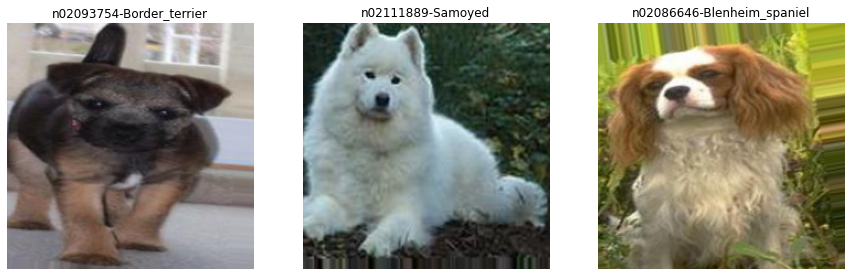

In [ ]:
# We visualize three random images from the dataset
# Random Iterator
randomIter = trainingIdg.flow_from_directory(
    trainingDirectory,
    target_size=(imgSize,imgSize),
    batch_size=1,
    class_mode='categorical',
    subset='training'
)

# Graph 3 random dogs with their classification
plt.figure(figsize=(15,10))
for i in range(3):
    randimg = next(randomIter)
    classi = list(randomIter.class_indices.keys())[list(randomIter.class_indices.values()).index(np.argmax(randimg[1]))]

    plt.subplot(1,3,i+1)
    plt.title(classi)
    plt.imshow(randimg[0].reshape(imgSize, imgSize, 3))
    plt.axis('off')

## 3. InceptionV3 CNN

Compared to the pre-training method that we saw and used in classes (the VGG16) for this work we decided to use a pre-trained model called Inceptionv3, which is a convolutional neural network that helps with image analysis and detection of objects.

In [ ]:
# InceptionV3 Pre-trained Model
# https://keras.io/api/applications/

inputs = keras.Input(shape=(imgSize, imgSize, 3))
base_model = keras.applications.InceptionV3(
    weights = 'imagenet',
    input_shape=(imgSize, imgSize, 3),
    include_top=False)
base_model.trainable = False

# Architecture
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(classNum, activation='softmax')(x)

# Model is built
model = keras.Model(base_model.input, outputs)

# Freeze Layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_96[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## 3.1 Loading of checkpoints

We only run this code block if we want to load checkpoints. We did encounter a lot of problems during training given that our computers are not equipped for machine learning. So we researched this method that automatically saves checkpoints of the model while its training so we can load them later.

In [ ]:
# Configure callback of checkpoints
# https://keras.io/api/callbacks/model_checkpoint/

import os
#os.mkdir('training')
#checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_path = "training/cp-best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    verbose=1,
    save_weights_only = True,
    monitor='val_accuracy',
    save_best_only = True, # We only save the best checkpoint
    mode='max' # according to the validation accuracy
    #period = 25 # We save the model every 50 epoch
)

In [ ]:
# Pick the last checkpoint from the training folder
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

# Load weights of the last checkpoint
model.load_weights(latest)
loss, acc = model.evaluate(testingGen)
print(f"val_loss: {round(loss*100,2)}%, val_acc:{round(acc*100,2)}%")

training/cp-best.ckpt
64/64 [==============================] - 16s 253ms/step - loss: 1.5138 - accuracy: 0.5958
val_loss: 151.38%, val_acc:59.58%


## 3.2 Training of the model

We train the model and also save the history of the accuracy, loss, validation accuracy and validation loss in 'history'.

This is only a test run to simulate the training we did.

In [ ]:
history = model.fit(
    trainingGen,
    steps_per_epoch=80,  
    epochs=25,
    verbose=1,
    validation_data=testingGen,
    validation_steps=50,
    callbacks=[cp_callback]
)

Epoch 1/25
80/80 [==============================] - 89s 1s/step - loss: 0.3104 - accuracy: 0.8955 - val_loss: 0.8379 - val_accuracy: 0.8247
Epoch 2/25
80/80 [==============================] - 85s 1s/step - loss: 0.2935 - accuracy: 0.9096 - val_loss: 0.7707 - val_accuracy: 0.8172
Epoch 3/25
80/80 [==============================] - 85s 1s/step - loss: 0.2826 - accuracy: 0.9101 - val_loss: 0.7176 - val_accuracy: 0.8294
Epoch 4/25
80/80 [==============================] - 85s 1s/step - loss: 0.2911 - accuracy: 0.9059 - val_loss: 0.7622 - val_accuracy: 0.8344
Epoch 5/25
80/80 [==============================] - 86s 1s/step - loss: 0.3011 - accuracy: 0.9049 - val_loss: 0.8061 - val_accuracy: 0.8203

Epoch 00005: saving model to training/cp-0005.ckpt
Epoch 6/25
80/80 [==============================] - 84s 1s/step - loss: 0.2905 - accuracy: 0.9055 - val_loss: 0.7930 - val_accuracy: 0.8300
Epoch 7/25
80/80 [==============================] - 84s 1s/step - loss: 0.2706 - accuracy: 0.9111 - val_loss

In [ ]:
# To save the model
model.save("perritos6.model", save_format="h5")

## 3.3 Upload to Google Drive

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 3.4 Restoring the model

Here, we are going to download the model we previously trained for 1300 epochs. 

In [ ]:
# Downloading the model we previously trained
!gdown --id 1QFm-0euGMhN9HizDnocgmo8ox3voaMMT # perritos 224
!gdown --id 1R0_ITqXQlWG1zcNl5hBRRjOjiRFdKtpS # perritos 125

Downloading...
From: https://drive.google.com/uc?id=1-CBc4CijFNnRqh73g3Isj94PSaroUbtX
To: /content/perritos.model
1.40GB [00:12, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-qUmyGn8HXDuj0dEWcXK9xPKIgaNJXpa
To: /content/perritos125.model
343MB [00:05, 59.3MB/s]


In [ ]:
# We load our model
model = keras.models.load_model('perritos224.model') # Modelo de 224x224
#model = keras.models.load_model('perritos125.model') # Modelo de 125x125

In [ ]:
# We evaluate our model with the testing dataset
loss, acc = model.evaluate(testingGen)
print(f"val_loss: {round(loss*100,2)}%, val_acc:{round(acc*100,2)}%")

64/64 [==============================] - 42s 658ms/step - loss: 0.7650 - accuracy: 0.8239
val_loss: 76.5%, val_acc:82.39%


## 4. Analyzing the data

We are going to plot the data se we can analyze it.
Here we only use the test run from this notebook to simulate the plotting we did.

At the end, we got 75% accuracy and 60% validation accuracy.

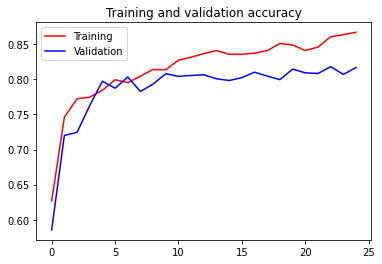

<Figure size 432x288 with 0 Axes>

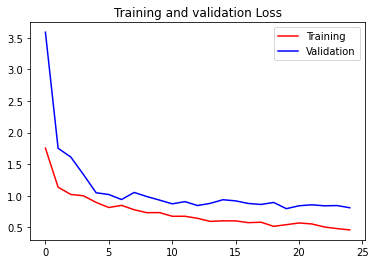

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

## Epochs from 1-25
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## 5. Testing the model

Now we test the model with images downloaded from internet. First, we built a function which is main objective is to download an image from a given url and then predicting the breed of the dog using our model.



## 5.1 Images from the internet

We can observe that our model correctly predicts the breed out of some pictures of the dogs we can find on the internet. we also show some other percentages of other breeds that made it to the top 5.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import preprocess_input
from PIL import Image
import urllib

def predictUrl(url):
    img = Image.open(urllib.request.urlopen("https://i.imgur.com/UKdWcVk.png"))
    img = img.convert('RGB')
    img = img.resize((imgSize, imgSize))
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:4]:
        print(f"{round(probs[0][idx]*100,2)}% \t", list(trainingGen.class_indices.keys())[idx][10:])

90.02% 	 Samoyed
6.2% 	 Great_Pyrenees
3.76% 	 kuvasz
0.0% 	 standard_poodle


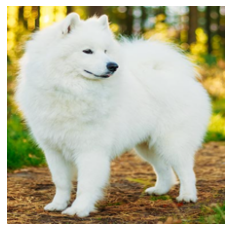

In [ ]:
predictUrl("https://i.imgur.com/UKdWcVk.png")

99.26% 	 Saluki
0.18% 	 English_foxhound
0.15% 	 whippet
0.09% 	 redbone


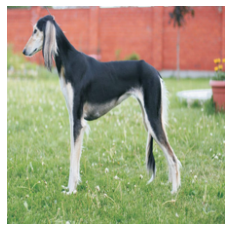

In [ ]:
predictUrl("https://jelenadogshows.com/eng/wp-content/uploads/2020/07/saluki.jpg")

91.75% 	 African_hunting_dog
5.69% 	 Mexican_hairless
2.38% 	 dhole
0.05% 	 Scottish_deerhound


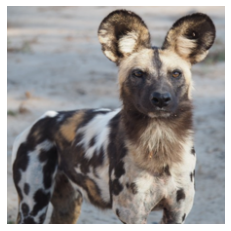

In [ ]:
predictUrl("https://i.imgur.com/lacYges.png")

90.97% 	 German_shepherd
5.13% 	 Pembroke
1.5% 	 malinois
1.18% 	 kelpie


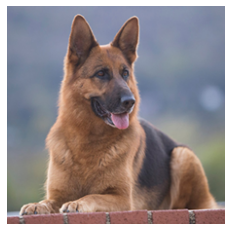

In [ ]:
predictUrl("https://kc-media-cdn-live.azureedge.net/cache/a/3/b/3/8/2/a3b382340f57e8d45582a14a9dffc701cf061f7e.jpg")

99.87% 	 malinois
0.06% 	 Leonberg
0.02% 	 Norwegian_elkhound
0.01% 	 Ibizan_hound


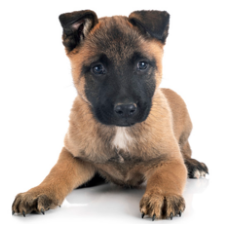

In [ ]:
predictUrl("https://i.imgur.com/5l8kJpN.png")

# ¿Qué raza es Alphonse?

###### No, en serio. ¿Qué raza es?

84.63% 	 Labrador_retriever
5.44% 	 Siberian_husky
4.75% 	 golden_retriever
1.11% 	 kuvasz


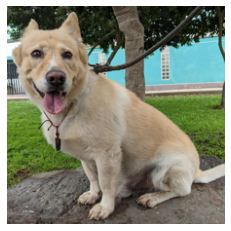

In [ ]:
# ALPHONSE
predictUrl("https://i.imgur.com/0VvP2kG.jpg")

97.86% 	 Yorkshire_terrier
1.26% 	 West_Highland_white_terrier
0.38% 	 Maltese_dog
0.14% 	 Scotch_terrier


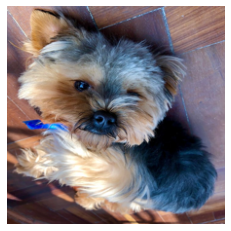

In [ ]:
# BENGY
predictUrl("https://i.imgur.com/SwNY7Rl.png")

99.82% 	 Maltese_dog
0.08% 	 West_Highland_white_terrier
0.02% 	 Shih-Tzu
0.02% 	 Lhasa


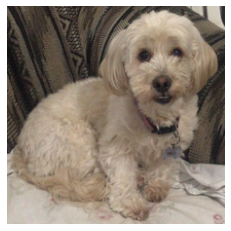

In [ ]:
# MOLLY
predictUrl("https://i.imgur.com/yxtTMjC.png")